In [1]:
import requests
import json
import pandas as pd
import numpy as np
import elasticsearch

In [2]:
class BlockNEO:
    
    neo_url = 'http://seed2.neo.org:10332'
    
    def __init__(self, numOfBlock):
        self.numOfBlock = numOfBlock
        self.blockToDataFrame()
        
    def makeGetBlockRequest(self):
        return json.dumps({
            "jsonrpc": "2.0",
            "method": "getblock",
            "params": [self.numOfBlock, 1],
            "id": 1
        })
    
    def getBlockDataDict(self):
        r = requests.post(self.neo_url, data = self.makeGetBlockRequest(), 
                          headers={"content-type": "application/json"})
        self.blockDict = json.loads(r.text)['result']
        
    def blockToDataFrame(self):
        self.getBlockDataDict()
        self.blockDataFrame = pd.DataFrame([[self.blockDict['hash'], self.blockDict['index'], self.blockDict['time'], 
                                      self.blockDict['confirmations'], len(self.blockDict['tx'])]],
                       columns=['Hash', 'BlockIndex', 'Time', 'Confirmations', 'Transactions'])

In [7]:
class DataFrameNeo:
    
    neo_url = 'http://seed2.neo.org:10332'
    
    def __init__(self):
        self.data = pd.DataFrame(columns=['Hash', 'BlockIndex', 'Time', 'Confirmations', 'Transactions'])
        
    def addBlockToDataFrame(self, blockNum):
        self.data = self.data.append(BlockNEO(blockNum).blockDataFrame)
        
    def makeMaxBlockCountRequest(self):
        return json.dumps({
            "jsonrpc": "2.0",
            "method": "getblockcount",
            "params": [],
            "id": 1
        })
    
    def getMaxBlockCount(self):
        r = requests.post(self.neo_url, data = self.makeMaxBlockCountRequest(), 
                          headers={"content-type": "application/json"})
        self.currentMaxBlockCount = json.loads(r.text)['result']
        
    def getCurrentBlockCount(self):
        if np.isnan(self.data.index.max()):
            self.currentBlockCount = 0
        else:
            self.currentBlockCount = int(self.data.index.max())
        
    def indexDataFrame(self):
        self.getMaxBlockCount()
        self.getCurrentBlockCount()
        try:
            self.currentMaxBlockCount = 1000
            for i in range(self.currentBlockCount, self.currentMaxBlockCount):
                self.addBlockToDataFrame(i)
        except Exception as e:
            print('Failed: '+ str(e))
        self.data['Index'] = self.data['BlockIndex']
        self.data = self.data.set_index('Index')

In [4]:
class ElasticSearchNeo:
    
    elasticURL = 'http://localhost:9200'
    neo_url = 'http://seed2.neo.org:10332'
    elasticMaxSize = 25
    elasticTimeout = 30
    elasticMaxRetries = 10
    indexName = "block_neo"
    
    def __init__(self):
        self.elasticDatabase = elasticsearch.Elasticsearch([self.elasticURL], maxsize = self.elasticMaxSize,
                                            timeout = self.elasticTimeout, max_retries = self.elasticMaxRetries, 
                                            retry_on_timeout=True)
        
    def indexBlock(self, blockNum):
        b = BlockNEO(blockNum)
        b.getBlockDataDict()
        self.elasticDatabase.index(index = self.indexName, doc_type='b', id = blockNum, body=b.blockDict)
        
    def makeMaxBlockCountRequest(self):
        return json.dumps({
            "jsonrpc": "2.0",
            "method": "getblockcount",
            "params": [],
            "id": 1
        })
    
    def getMaxBlockCount(self):
        r = requests.post(self.neo_url, data = self.makeMaxBlockCountRequest(), 
                          headers={"content-type": "application/json"})
        self.currentMaxBlockCount = json.loads(r.text)['result']
    
    def getCurrentBlockCount(self):
        try:
            self.currentBlockCount = elasticsearch.Elasticsearch([self.elasticURL]).count(index = self.indexName, 
                                                                                         doc_type = 'b')['count']
        except:
            self.currentBlockCount = 0
        
    def indexDatabase(self):
        self.getMaxBlockCount()
        self.getCurrentBlockCount()
        try:
            #self.currentMaxBlockCount = 10
            for i in range(self.currentBlockCount + 1, self.currentMaxBlockCount):
                self.indexBlock(i)
        except Exception as e:
            print('Failed: '+ str(e))
        self.getCurrentBlockCount()

    def clearDatabase(self):
        self.elasticDatabase.indices.delete(index = self.indexName, ignore = [400, 404])

In [14]:
#Get Pandas DataFrame
#df = DataFrameNeo()
#df.indexDataFrame()
#df.data

In [16]:
#Get ElasticSearch DataBase
#e = ElasticSearchNeo()
#e.clearDatabase()
#e.indexDatabase()

In [28]:
#Statistic for the first 1000 blocks
#df = DataFrameNeo()
#df.indexDataFrame()
df['hours'] = pd.to_datetime(df['Time'],unit='s').dt.hour
df['datetime'] = pd.to_datetime(df['Time'],unit='s')

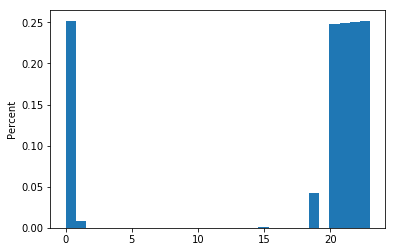

In [30]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(df['hours'], normed=True, bins=30)
plt.ylabel('Percent');

In [68]:
a.indexDataFrame()

In [70]:
a.data

,Hash,BlockIndex,Time,Confirmations,Transactions
Index,,,,,
0,0xd42561e3d30e15be6400b6df2f328e02d2bf6354c41d...,0,1468595301,2006439,4
1,0xd782db8a38b0eea0d7394e0f007c61c71798867578c7...,1,1476647382,2006438,1
2,0xbf638e92c85016df9bc3b62b33f3879fa22d49d5f55d...,2,1476647402,2006437,1
3,0x1fca8800f1ffbc9fb08bcfee1269461161d58dcee025...,3,1476647418,2006436,1
4,0xbde9267017e354b9b9f7d46ffb99db1d6464812838f5...,4,1476647441,2006435,1
5,0xff8fe95efc5d1cc3a22b17503aecaf289cef68f94b79...,5,1476647460,2006434,1
6,0xf07994eaad487e039840a565c844b5f5293f45abf15f...,6,1476647478,2006433,1
7,0x1b327ce183d004e6e898630a1ebcf29fff2029e6b6da...,7,1476647488,2006432,1
8,0x59cc31bb51354c9eb251545bb39dfb35b0d31b713baf...,8,1476647517,2006431,1
